# Tutorial for anndata

https://scverse-tutorials.readthedocs.io/en/latest/notebooks/anndata_getting_started.html

# Calculate and plot coexpression:

https://github.com/scverse/scanpy/issues/490

## 1. Import libraries

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from CSCORE import CSCORE

## 2. Read dataset

In [2]:
# Загрузка данных Human Brain Cell Atlas v1.0 (https://cellxgene.cziscience.com/collections/283d65eb-dd53-496d-adb7-7570c7caa443)
adata = sc.read('60591892-d938-4cdb-8545-3d84d5c16571.h5ad')

In [3]:
# Посмотрим, что представляет собой объект adata
adata

AnnData object with n_obs × n_vars = 107301 × 59236
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE'

In [5]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 571420403 stored elements and shape (107301, 59236)>

**В датасете отсутствует слой с сырыми данными!**

In [4]:
adata.raw is None

True

## 3. Загружаем список генов интереса: в данном случае это гены PcG

In [6]:
# Read TSV file with PcG genes (https://docs.google.com/spreadsheets/d/1OX1sBCH3fzR3Tg6BkdOtihMl7DHW2uyxMQnYPy-HMzQ/edit?usp=sharing)
polycomb_genes=pd.read_csv('../data/Polycomb_proteins.tsv', sep='\t')

In [7]:
# Проверяем, что гены успешно загружены
polycomb_genes.head()

,Name,Ensembl_ID,UniprotKB,Other_names,Function,Domain,Complex,Type
0,RING1A,ENSG00000204227,Q06587,RNF1,Ubiquitinates H2AK119,RING finger,PRC1,Core
1,RING1B,ENSG00000121481,Q99496,RNF2,Ubiquitinates H2AK119,RING finger,PRC1,Core
2,CBX2,ENSG00000173894,Q14781,NaN,"Bind H3K27me3, H3K9me3",Chromodomain; AT hook,PRC1,cPRC1
3,CBX4,ENSG00000141582,O00257,NaN,"Bind H3K27me3, H3K9me4",Chromodomain,PRC1,cPRC1
4,CBX6,ENSG00000183741,O95503,NaN,"Bind H3K27me3, H3K9me5",Chromodomain,PRC1,cPRC1


In [8]:
# Cписок генов Polycomb Group Complex: Select Ensembl_ID
genes_of_interest = polycomb_genes['Ensembl_ID'].to_list()

## 4. Фильтруем датасет, убирая все гены, кроме генов интереса

In [9]:
# Filter dataset:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [10]:
# Фильтрация данных по интересующим генам:
adata_filtered = adata[:, adata.var_names.isin(genes_of_interest)]

In [11]:
# Проверяем резульаты фильтрации
adata_filtered

View of AnnData object with n_obs × n_vars = 107301 × 53
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE'

In [67]:
# Проверка наличия генов в данных
print("Гены в данных:", adata_filtered.var_names.to_list())

# Перезаписываем список генов в учётом тех, которые не прошли отбор по качеству:
genes_of_interest = adata_filtered.var_names.to_list()

# Общее количество генов PcG:
len(genes_of_interest)

Гены в данных: ['ENSG00000146285', 'ENSG00000185513', 'ENSG00000156374', 'ENSG00000162521', 'ENSG00000143970', 'ENSG00000143033', 'ENSG00000196233', 'ENSG00000178691', 'ENSG00000139154', 'ENSG00000100395', 'ENSG00000134686', 'ENSG00000180628', 'ENSG00000102098', 'ENSG00000108799', 'ENSG00000168283', 'ENSG00000125952', 'ENSG00000174197', 'ENSG00000173889', 'ENSG00000141431', 'ENSG00000185619', 'ENSG00000198945', 'ENSG00000183741', 'ENSG00000141582', 'ENSG00000163935', 'ENSG00000119403', 'ENSG00000085185', 'ENSG00000277258', 'ENSG00000112511', 'ENSG00000089094', 'ENSG00000008083', 'ENSG00000010803', 'ENSG00000158321', 'ENSG00000111752', 'ENSG00000115289', 'ENSG00000121481', 'ENSG00000112787', 'ENSG00000047634', 'ENSG00000198176', 'ENSG00000156860', 'ENSG00000106462', 'ENSG00000074266', 'ENSG00000171456', 'ENSG00000154655', 'ENSG00000100307', 'ENSG00000102054', 'ENSG00000015153', 'ENSG00000204227', 'ENSG00000273604', 'ENSG00000178177', 'ENSG00000163602', 'ENSG00000169016', 'ENSG0000014157

53

## 5. Build UMAPS and t-SNE

In [30]:
# UMAP extraction:
neurons.obsm

AxisArrays with keys: X_UMAP, X_tSNE

In [32]:
neurons.obsm.keys()

KeysView(AxisArrays with keys: X_UMAP, X_tSNE)

In [33]:
for key in neurons.obsm_keys():
    print(key, adata.obsm[key].shape, sep="\t")

X_UMAP	(107301, 2)
X_tSNE	(107301, 2)


### 5.1. Строим UMAP и t-SNE по типу клеток: 1 - нейрон, 0 - не нейрон

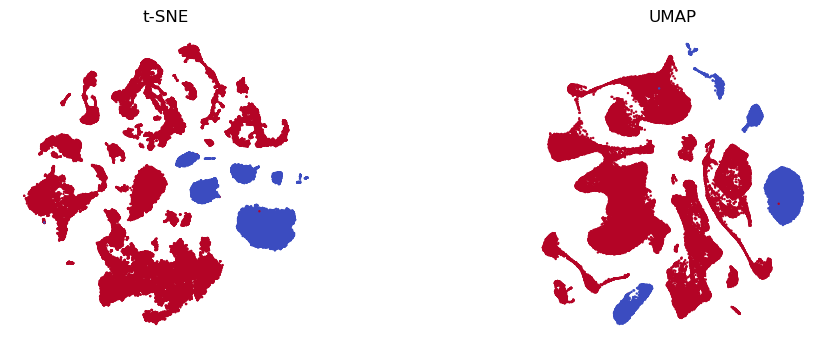

In [50]:
plt.figure(figsize=(12, 4))

# t-SNE
plt.subplot(1, 2, 1)
plt.scatter(
    x=adata.obsm["X_tSNE"][:, 0],  # t-SNE dim 1
    y=adata.obsm["X_tSNE"][:, 1],  # t-SNE dim 2
    c=adata.obs["cell_type"] == "neuron",  #flag
    s=3,
    linewidth=0,
    cmap="coolwarm",
)
plt.title("t-SNE")
plt.axis("off")
plt.gca().set_aspect("equal")

# UMAP
plt.subplot(1, 2, 2)
plt.scatter(
    x=adata.obsm["X_UMAP"][:, 0],  # UMAP dim 1
    y=adata.obsm["X_UMAP"][:, 1],  # UMAP dim 2
    c=adata.obs["cell_type"] == "neuron",  # cell type flag
    s=3,
    linewidth=0,
    cmap="coolwarm",
)
plt.title("UMAP")
plt.axis("off")
plt.gca().set_aspect("equal")

### 5.2 Записываем слой сырых данных данными из активного слоя adata

In [55]:
adata.raw = adata.copy()

In [77]:
adata.raw

In [78]:
adata.raw.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 571415589 stored elements and shape (107301, 40800)>

### 5.3. Считаем и рисуем коэкспрессию для пары генов **ENSG00000158321** и **ENSG00000139154**

**Получаем булевы значения: 0 - не коэкспрессируются, 1 - коэкспрессируются**

In [56]:
gene1 = 'ENSG00000158321'
gene2 = 'ENSG00000139154'

adata.obs['CoEx'] = (adata.raw[:,'{}'.format(gene1)].X.todense() > 0) & (adata.raw[:,'{}'.format(gene2)].X.todense() > 0)

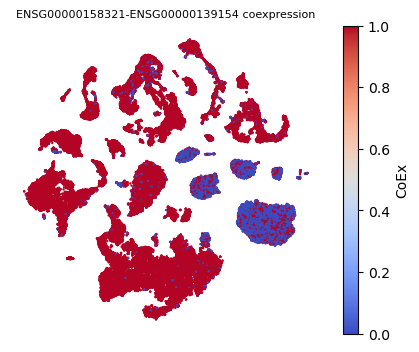

In [65]:
plt.figure(figsize=(12, 4))

# t-SNE
ax = plt.subplot(1, 2, 1)
sc = ax.scatter(
    x=adata.obsm["X_tSNE"][:, 0],  # t-SNE dim 1
    y=adata.obsm["X_tSNE"][:, 1],  # t-SNE dim 2
    c=adata.obs['CoEx'],  # coexpression flag
    s=3,
    linewidth=0,
    cmap="coolwarm",
)
ax.set_title(f"{gene1}-{gene2} coexpression", fontsize=8)
ax.axis("off")
ax.set_aspect("equal")

# Добавляем цветовую шкалу (легенду), указывая ось
plt.colorbar(sc, ax=ax, label='CoEx')

### 5.4. Считаем и рисуем коэкспрессию для другой пары генов из списка генов PcG

**Получаем булевы значения: 0 - не коэкспрессируются, 1 - коэкспрессируются**

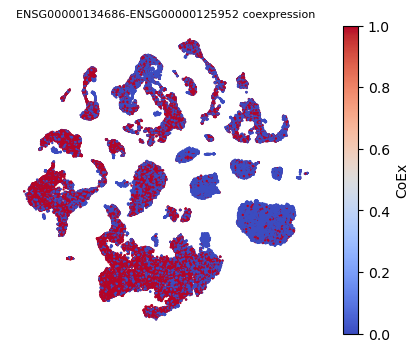

In [66]:
gene1 = genes_of_interest[10]
gene2 = genes_of_interest[15]

adata.obs['CoEx'] = (adata.raw[:,'{}'.format(gene1)].X.todense() > 0) & (adata.raw[:,'{}'.format(gene2)].X.todense() > 0)

plt.figure(figsize=(12, 4))

# t-SNE
ax = plt.subplot(1, 2, 1)
sc = ax.scatter(
    x=adata.obsm["X_tSNE"][:, 0],  # t-SNE dim 1
    y=adata.obsm["X_tSNE"][:, 1],  # t-SNE dim 2
    c=adata.obs['CoEx'],  # flag
    s=3,
    linewidth=0,
    cmap="coolwarm",
)
ax.set_title(f"{gene1}-{gene2} coexpression", fontsize=8)
ax.axis("off")
ax.set_aspect("equal")

# Добавляем цветовую шкалу (легенду), указывая ось
plt.colorbar(sc, ax=ax, label='CoEx')

### 5.5. Считаем и рисуем коэкспрессию для первых 12 пар генов

**Получаем булевы значения: 0 - не коэкспрессируются, 1 - коэкспрессируются**

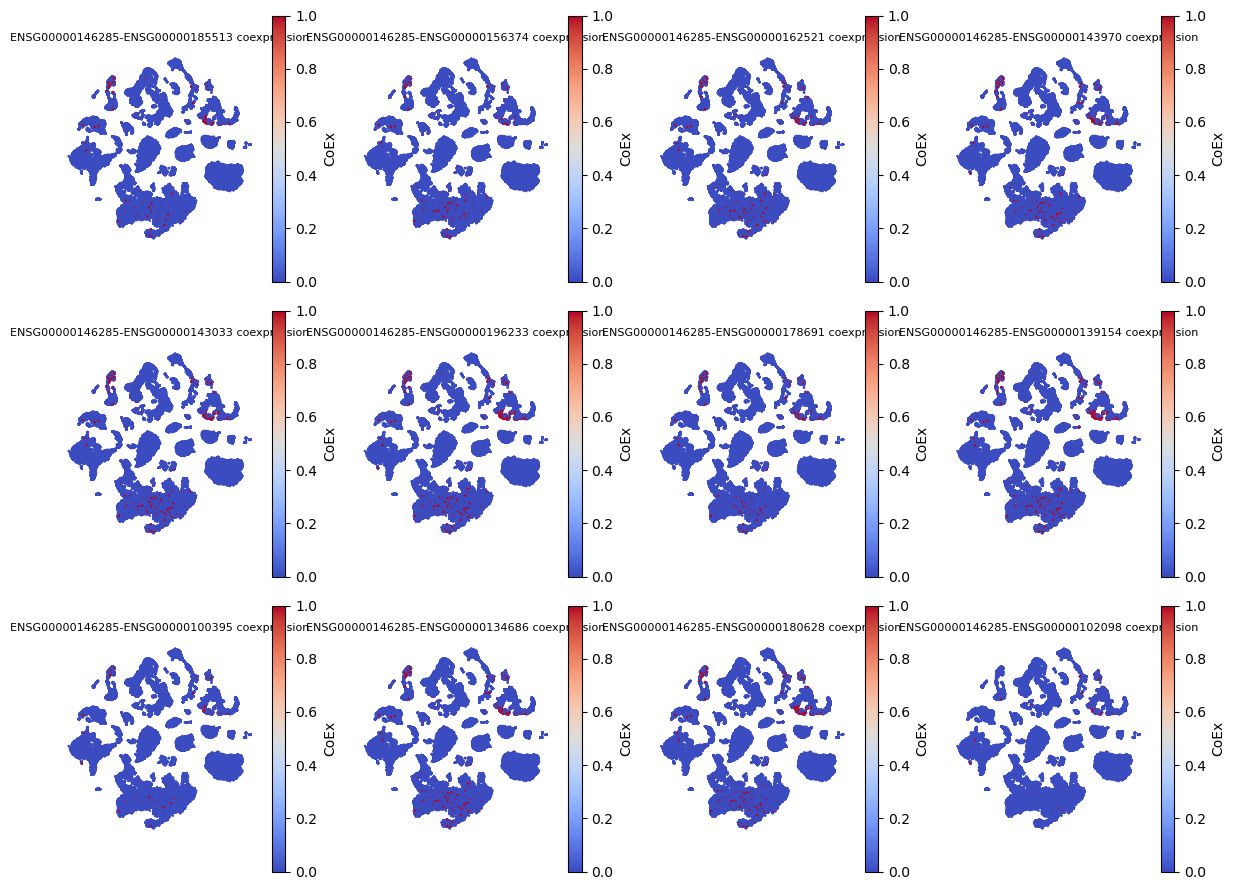

In [68]:
# Получаем общее количество генов интереса:
num_genes = len(genes_of_interest)

num_plots_to_show = 12  # Количество графиков для отображения
num_plots_per_row = 4   # Количество графиков в строке
num_rows = (num_plots_to_show + num_plots_per_row - 1) // num_plots_per_row  # Количество строк

plt.figure(figsize=(12, num_rows * 3))

plot_index = 0

# Перебираем все уникальные пары генов
for i in range(num_genes):
    for j in range(i + 1, num_genes):
        gene1 = genes_of_interest[i]
        gene2 = genes_of_interest[j]

        # Создаем новую колонку 'CoEx' для текущей пары генов
        adata.obs['CoEx'] = (adata.raw[:, gene1].X.todense() > 0) & (adata.raw[:, gene2].X.todense() > 0)

        # Создаем сабплот
        ax = plt.subplot(num_rows, num_plots_per_row, plot_index + 1)
        sc = ax.scatter(
            x=adata.obsm["X_tSNE"][:, 0],  # t-SNE dim 1
            y=adata.obsm["X_tSNE"][:, 1],  # t-SNE dim 2
            c=adata.obs['CoEx'],  # flag
            s=3,
            linewidth=0,
            cmap="coolwarm",
        )
        ax.set_title(f"{gene1}-{gene2} coexpression", fontsize=8)
        ax.axis("off")
        ax.set_aspect("equal")

        # Добавляем цветовую шкалу (легенду), указывая ось
        plt.colorbar(sc, ax=ax, label='CoEx')

        plot_index += 1
        
        # Останавливаемся после отображения первых num_plots_to_show графиков
        if plot_index >= num_plots_to_show:
            break
    if plot_index >= num_plots_to_show:
        break

plt.tight_layout()
plt.show()

### 5.6. Считаем и рисуем коэкспрессию для первых 12 пар генов, у которых **средняя коэкспрессия по всем клеткам выше 0.6**

**Получаем булевы значения: 0 - не коэкспрессируются, 1 - коэкспрессируются**

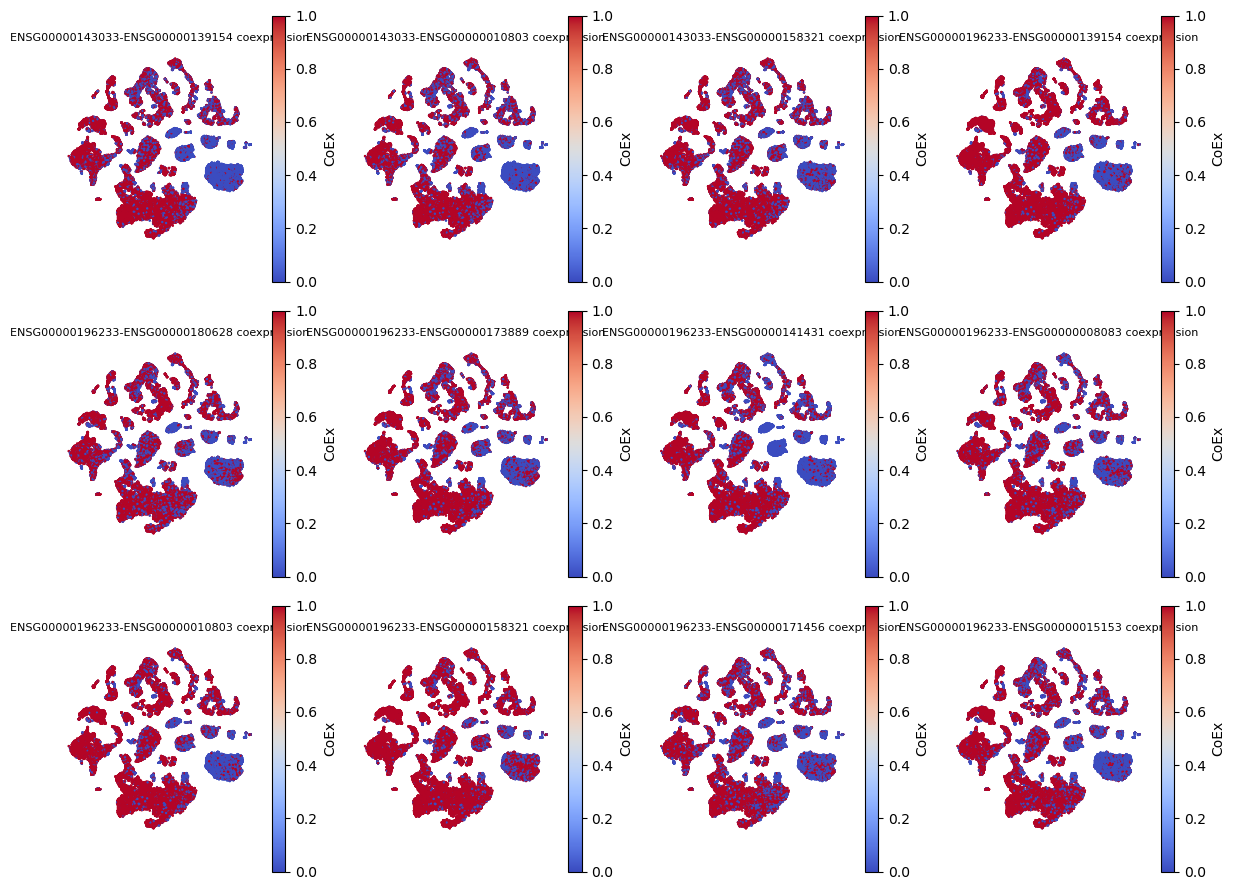

In [69]:
num_genes = len(genes_of_interest)
num_plots_to_show = 12  # Количество графиков для отображения
num_plots_per_row = 4   # Количество графиков в строке
num_rows = (num_plots_to_show + num_plots_per_row - 1) // num_plots_per_row  # Количество строк

plt.figure(figsize=(12, num_rows * 3))

plot_index = 0

# Перебираем все уникальные пары генов
for i in range(num_genes):
    for j in range(i + 1, num_genes):
        gene1 = genes_of_interest[i]
        gene2 = genes_of_interest[j]

        # Создаем новую колонку 'CoEx' для текущей пары генов
        adata.obs['CoEx'] = (adata.raw[:, gene1].X.todense() > 0) & (adata.raw[:, gene2].X.todense() > 0)

        # Проверяем среднее значение CoEx
        if np.mean(adata.obs['CoEx']) > 0.6:
            # Создаем сабплот
            ax = plt.subplot(num_rows, num_plots_per_row, plot_index + 1)
            sc = ax.scatter(
                x=adata.obsm["X_tSNE"][:, 0],  # t-SNE dim 1
                y=adata.obsm["X_tSNE"][:, 1],  # t-SNE dim 2
                c=adata.obs['CoEx'],  # flag
                s=3,
                linewidth=0,
                cmap="coolwarm",
            )
            ax.set_title(f"{gene1}-{gene2} coexpression", fontsize=8)
            ax.axis("off")
            ax.set_aspect("equal")

            # Добавляем цветовую шкалу (легенду), указывая ось
            plt.colorbar(sc, ax=ax, label='CoEx')

            plot_index += 1
            
            # Останавливаемся после отображения первых num_plots_to_show графиков
            if plot_index >= num_plots_to_show:
                break
    if plot_index >= num_plots_to_show:
        break

plt.tight_layout()
plt.show()

### 5.7. Считаем коэкспрессию для всех пар генов PcG

- Для каждой отдельной клетки коэкспрессия имеет булево значение: 0 - не коэкспрессируются, 1 - коэкспрессируются
- Для матрицы мы считаем среднее по всем клеткам и получаем число *float* от 0 до 1

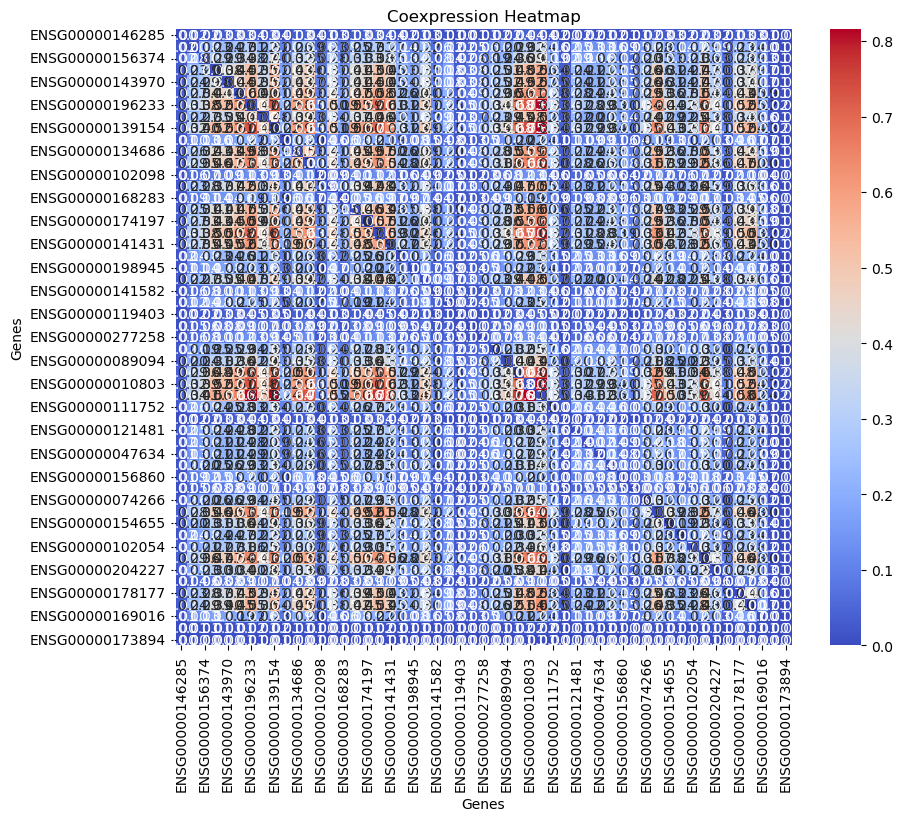

In [70]:
# Создаем пустую матрицу для хранения значений CoEx
coex_matrix = np.zeros((num_genes, num_genes))

# Заполняем матрицу значениями CoEx для каждой пары генов
for i in range(num_genes):
    for j in range(num_genes):
        if i == j:  # Если это диагональный элемент, задаем значение 1
            coex_matrix[i, j] = 1.0
        else:  # Для остальных пар генов
            gene1 = genes_of_interest[i]
            gene2 = genes_of_interest[j]

            # Создаем новую колонку 'CoEx' для текущей пары генов
            adata.obs['CoEx'] = (adata.raw[:, gene1].X.todense() > 0) & (adata.raw[:, gene2].X.todense() > 0)

            # Сохраняем среднее значение CoEx в матрице
            coex_matrix[i, j] = np.mean(adata.obs['CoEx'])

# Преобразуем матрицу в DataFrame для удобства работы с seaborn
coex_df = pd.DataFrame(coex_matrix, index=genes_of_interest, columns=genes_of_interest)

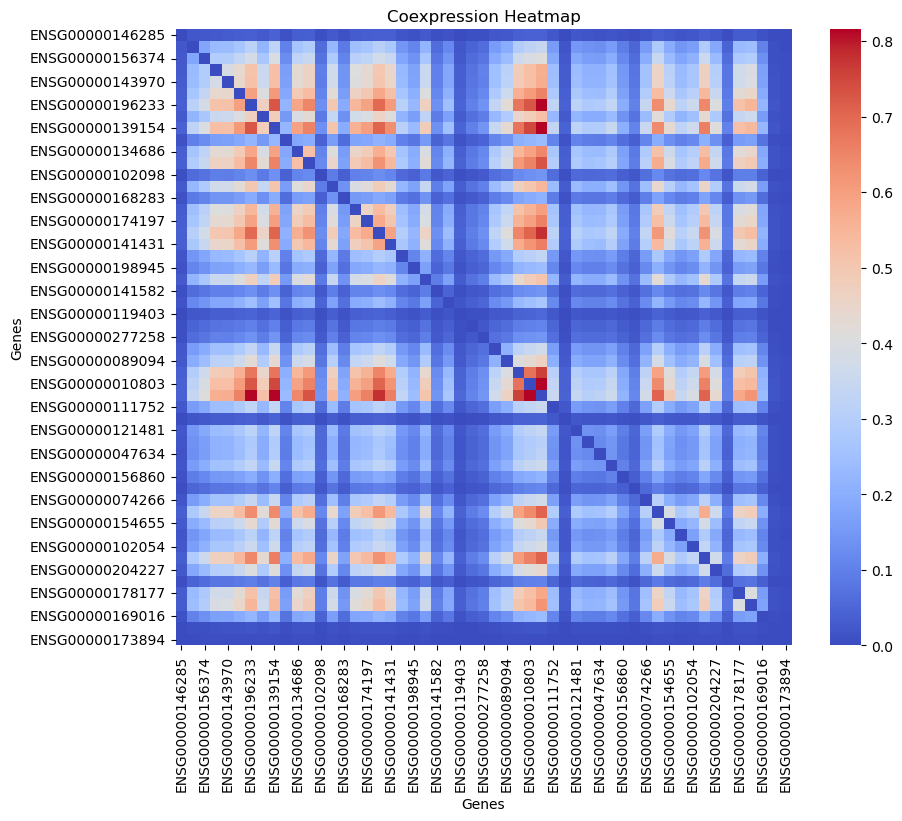

In [71]:
# Строим тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(coex_df, cmap="coolwarm", annot=False, fmt=".2f", square=True)
plt.title("Coexpression Heatmap")
plt.xlabel("Genes")
plt.ylabel("Genes")
plt.show()

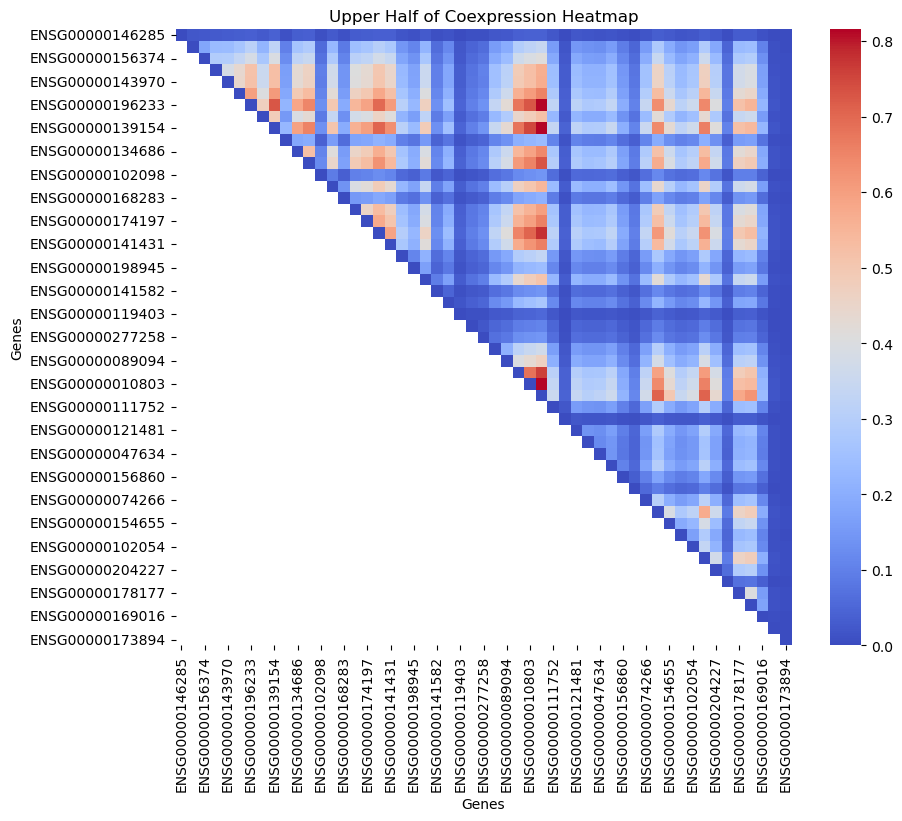

In [73]:
# Создаем половинчатую матрицу (например, верхнюю)
half_coex_df = coex_df.where(np.triu(np.ones(coex_df.shape), k=0).astype(bool))

# Строим тепловую карту для половинчатой матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(half_coex_df, cmap="coolwarm", annot=False, fmt=".2f", square=True)
plt.title("Upper Half of Coexpression Heatmap")
plt.xlabel("Genes")
plt.ylabel("Genes")
plt.show()

## 6. CS-CORE

### Опция: дополнительно фильтруем датасет, оставляя только нейроны

In [75]:
# focus on neurons
neurons = adata_filtered[adata_filtered.obs['cell_type'] == 'neuron',:]

# Check object:
neurons

View of AnnData object with n_obs × n_vars = 85093 × 53
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'CoEx'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_t

In [79]:
neurons.var.head()

,Biotype,Chromosome,End,Gene,Start,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,n_cells
ENSG00000146285,n/a,chr6,107824317,SCML4,107702154,False,SCML4,NCBITaxon:9606,gene,1749,protein_coding,4412
ENSG00000185513,n/a,chr20,43550954,L3MBTL1,43489442,False,L3MBTL1,NCBITaxon:9606,gene,2974,protein_coding,37005
ENSG00000156374,n/a,chr10,103351144,PCGF6,103302796,False,PCGF6,NCBITaxon:9606,gene,1950,protein_coding,44474
ENSG00000162521,n/a,chr1,32686211,RBBP4,32651142,False,RBBP4,NCBITaxon:9606,gene,690,protein_coding,61172
ENSG00000143970,n/a,chr2,25878487,ASXL2,25733753,False,ASXL2,NCBITaxon:9606,gene,2192,protein_coding,61622


In [15]:
# scale counts by seq depths
sc.pp.normalize_total(neurons, target_sum=1)

# calculate mean expression
mean_exp = (neurons.X).sum(axis=0).A1
mean_exp

/home/ivan/miniconda3/envs/scRNAseq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ivan/miniconda3/envs/scRNAseq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:243: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


array([7.5349350e+01, 5.9141168e+02, 7.9947644e+02, 1.2143262e+03,
       1.2906910e+03, 1.8997365e+03, 3.4968218e+03, 1.0746769e+03,
       8.1469351e+03, 3.5422110e+02, 1.6869159e+03, 2.3790503e+03,
       2.3084634e+02, 1.1633979e+03, 3.1077606e+02, 1.4836826e+03,
       1.7919479e+03, 2.9858281e+03, 3.1454805e+03, 5.2188818e+02,
       4.3382864e+02, 1.1880532e+03, 1.8484160e+02, 4.4891138e+02,
       6.3985207e+01, 1.3743988e+02, 2.0968402e+02, 6.1630750e+02,
       9.8216675e+02, 2.7351626e+03, 4.8322852e+03, 2.1895729e+04,
       5.8267365e+02, 5.4618938e+01, 5.8862231e+02, 4.6154199e+02,
       5.3732880e+02, 6.1822601e+02, 2.9219608e+02, 1.5870799e+02,
       6.2059570e+02, 2.0388132e+03, 2.5571309e+03, 5.6651581e+02,
       6.6418744e+02, 2.5587646e+03, 8.3664929e+02, 1.5041953e+02,
       1.7066398e+03, 1.3582170e+03, 3.3903659e+02, 1.8834810e+01,
       6.5860686e+00], dtype=float32)

In [74]:
mean_exp_df = pd.DataFrame({'gene': neurons.var.Gene, 'mean_expression': mean_exp})
mean_exp_df.head()

,gene,mean_expression
ENSG00000146285,SCML4,75.349350
ENSG00000185513,L3MBTL1,591.411682
ENSG00000156374,PCGF6,799.476440
ENSG00000162521,RBBP4,1214.326172
ENSG00000143970,ASXL2,1290.691040


In [17]:
top_genes_df = mean_exp_df.sort_values(by='mean_expression', ascending=False)
top_genes_df.head()

,gene,mean_expression
ENSG00000158321,AUTS2,21895.728516
ENSG00000139154,AEBP2,8146.935059
ENSG00000010803,SCMH1,4832.285156
ENSG00000196233,LCOR,3496.821777
ENSG00000141431,ASXL3,3145.480469


In [18]:
# reset indices:
top_genes_df = top_genes_df.reset_index()
top_genes_df.head()

,index,gene,mean_expression
0,ENSG00000158321,AUTS2,21895.728516
1,ENSG00000139154,AEBP2,8146.935059
2,ENSG00000010803,SCMH1,4832.285156
3,ENSG00000196233,LCOR,3496.821777
4,ENSG00000141431,ASXL3,3145.480469


In [19]:
# obtain indexes for the gene set of interest:
#genes_indices = top_genes_df.index.values.tolist()
genes_indices = top_genes_df.index.astype(int).to_numpy()
genes_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52])

In [20]:
neurons.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2169962 stored elements and shape (85093, 53)>

In [21]:
neurons.raw = neurons.copy()

In [25]:
neurons.raw is None

False

In [80]:
# res = CSCORE(neurons, genes_indices)